In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests
from joblib import Parallel, delayed

## FSD

In [2]:
def compute_fsd(returns_i, returns_j):
    """First-order stochastic dominance test statistic"""
    sorted_i = np.sort(returns_i)
    sorted_j = np.sort(returns_j)
    
    # Empirical CDFs
    cdf_i = np.arange(1, len(sorted_i)+1)/len(sorted_i)
    cdf_j = np.arange(1, len(sorted_j)+1)/len(sorted_j)
    
    # Combined grid
    grid = np.unique(np.concatenate([sorted_i, sorted_j]))
    F_i = np.searchsorted(sorted_i, grid, side='right')/len(sorted_i)
    F_j = np.searchsorted(sorted_j, grid, side='right')/len(sorted_j)
    
    test_stat = np.max(F_j - F_i)
    return test_stat

## SSD

In [3]:
def compute_ssd(returns_i, returns_j):
    """Second-order stochastic dominance test statistic"""
    sorted_i = np.sort(returns_i)
    sorted_j = np.sort(returns_j)
    
    # Integrated CDFs
    int_i = np.cumsum(sorted_i)/len(sorted_i)
    int_j = np.cumsum(sorted_j)/len(sorted_j)
    
    # Combined grid
    grid = np.unique(np.concatenate([sorted_i, sorted_j]))
    F_i = np.interp(grid, sorted_i, int_i, left=0, right=int_i[-1])
    F_j = np.interp(grid, sorted_j, int_j, left=0, right=int_j[-1])
    
    test_stat = np.max(F_j - F_i)
    return test_stat

## Other Helpers

In [4]:
def bootstrap_pvalue(returns_i, returns_j, test_func):
    """Bootstrap p-value calculation"""
    combined = np.concatenate([returns_i, returns_j])
    obs_stat = test_func(returns_i, returns_j)
    
    boot_stats = []
    for _ in range(N_BOOTSTRAP):
        sample_i = np.random.choice(combined, len(returns_i), replace=True)
        sample_j = np.random.choice(combined, len(returns_j), replace=True)
        boot_stats.append(test_func(sample_i, sample_j))
    
    return np.mean(np.array(boot_stats) >= obs_stat)

In [5]:
def run_dominance_tests(returns_df, order=1, n_jobs=-1):
    """Main testing procedure with parallel execution"""
    tickers = returns_df.columns.tolist()
    pairs = [(i, j) for i in tickers for j in tickers if i < j]
    
    test_func = compute_fsd if order == 1 else compute_ssd
    
    def process_pair(pair):
        i, j = pair
        returns_i = returns_df[i].dropna().values
        returns_j = returns_df[j].dropna().values
        
        if len(returns_i) < 10 or len(returns_j) < 10:
            return (i, j, np.nan, np.nan)
            
        test_stat = test_func(returns_i, returns_j)
        p_value = bootstrap_pvalue(returns_i, returns_j, test_func)
        return (i, j, test_stat, p_value)
    
    # Parallel execution
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_pair)(pair) for pair in tqdm(pairs, desc=f"Order {order} SD")
    )
    
    # Create DataFrame
    df = pd.DataFrame(results, columns=['Dominant', 'Dominated', 'Test Statistic', 'p-value'])
    
    # Multiple testing correction
    reject, adj_pvals, _, _ = multipletests(df['p-value'], alpha=ALPHA, method='holm')
    df['Adj. p-value'] = adj_pvals
    df['Significant'] = reject
    
    return df.sort_values('Test Statistic', ascending=False)

In [6]:
def visualize_dominance(results, title):
    """Network visualization of significant dominance relationships"""
    G = nx.from_pandas_edgelist(
        results[results['Significant']],
        'Dominant',
        'Dominated',
        create_using=nx.DiGraph()
    )
    
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.show()

In [7]:
def generate_report(fsd_results, ssd_results, filename='dominance_report.xlsx'):
    """Save results to Excel with formatted sheets"""
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        # FSD Results
        fsd_results.to_excel(writer, sheet_name='FSD Results', index=False)
        
        # SSD Results
        ssd_results.to_excel(writer, sheet_name='SSD Results', index=False)
        
        # Get workbook and worksheet objects
        workbook = writer.book
        
        # Formatting
        format_float = workbook.add_format({'num_format': '0.000'})
        format_pct = workbook.add_format({'num_format': '0.0%'})
        
        # Apply formats
        for sheet in ['FSD Results', 'SSD Results']:
            worksheet = writer.sheets[sheet]
            worksheet.set_column('C:D', 12, format_float)
            worksheet.set_column('E:E', 12, format_pct)
            worksheet.set_column('F:F', 12)

## Testing

In [8]:
hist_pct_ret = pd.read_csv('djia_hist_pct_ret.csv')
hist_pct_ret['Date'] = pd.to_datetime(hist_pct_ret['Date'])
hist_pct_ret.set_index('Date', inplace=True, drop=True)

In [9]:
np.random.seed(42)  # For reproducibility
N_BOOTSTRAP = 10000  # Reduce if computation is intensive
ALPHA = 0.05

In [10]:
fsd_results = run_dominance_tests(hist_pct_ret, order=1)

Order 1 SD:   0%|          | 0/435 [00:00<?, ?it/s]

Order 1 SD: 100%|██████████| 435/435 [09:50<00:00,  1.36s/it]


In [11]:
significant_fsd = fsd_results[fsd_results['p_value'] < 0.01]
dominance_counts = pd.DataFrame({
    'Dominant': int(significant_fsd['Dominant'].value_counts()),
    'Dominated': int(significant_fsd['Dominated'].value_counts())
}).fillna(0)
dominance_counts

,Dominant,Dominated
AAPL,4.0,0.0
AMGN,1.0,0.0
AMZN,7.0,0.0
BA,5.0,0.0
CAT,6.0,0.0
CRM,5.0,0.0
GS,4.0,0.0
HON,1.0,0.0
JNJ,1.0,6.0
JPM,2.0,0.0


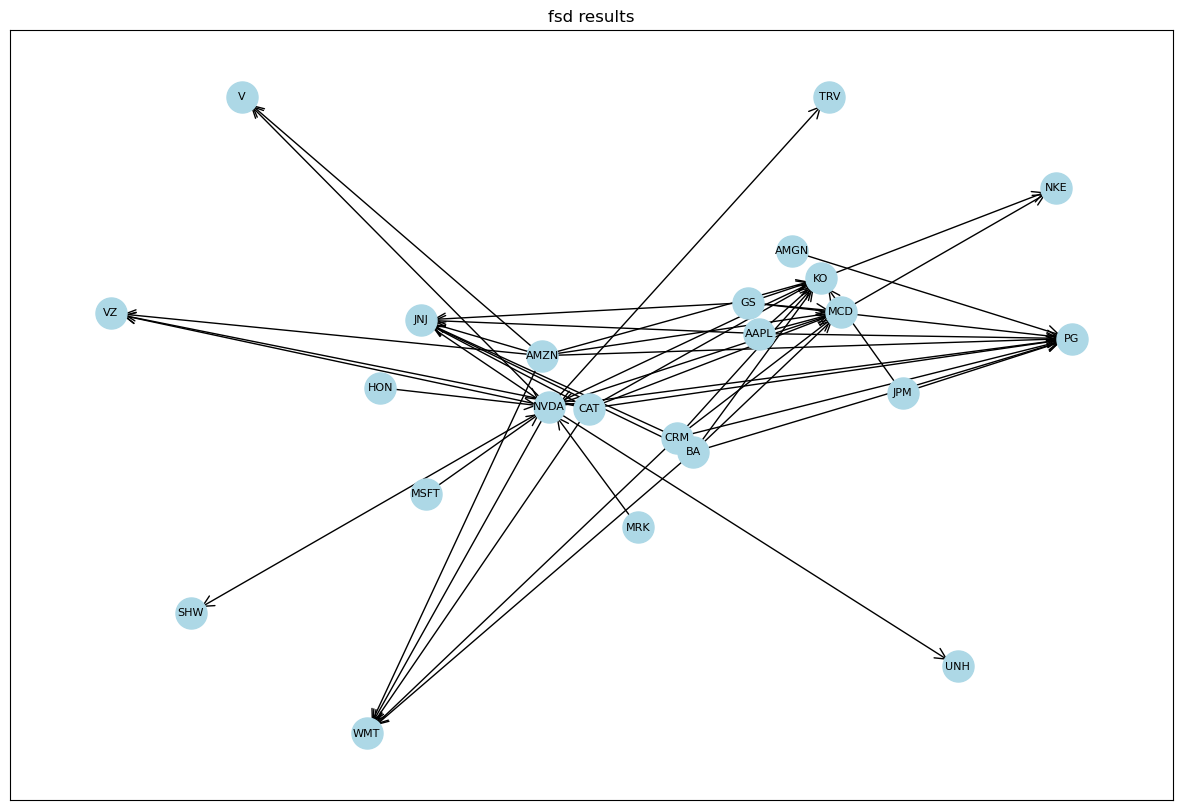

In [12]:
visualize_dominance(fsd_results,'fsd results')

In [13]:
ssd_results = run_dominance_tests(hist_pct_ret, order=2)

Order 2 SD: 100%|██████████| 435/435 [10:17<00:00,  1.42s/it]


In [14]:
significant_ssd = ssd_results[ssd_results['Significant']]
dominance_counts = pd.DataFrame({
    'Dominant': significant_ssd['Dominant'].value_counts(),
    'Dominated': significant_ssd['Dominated'].value_counts()
}).fillna(0)
dominance_counts

,Dominant,Dominated
BA,4.0,0.0
CRM,3.0,0.0
JNJ,1.0,2.0
KO,0.0,2.0
MCD,0.0,1.0
MRK,1.0,0.0
NKE,1.0,0.0
NVDA,3.0,2.0
PG,0.0,4.0
V,0.0,1.0


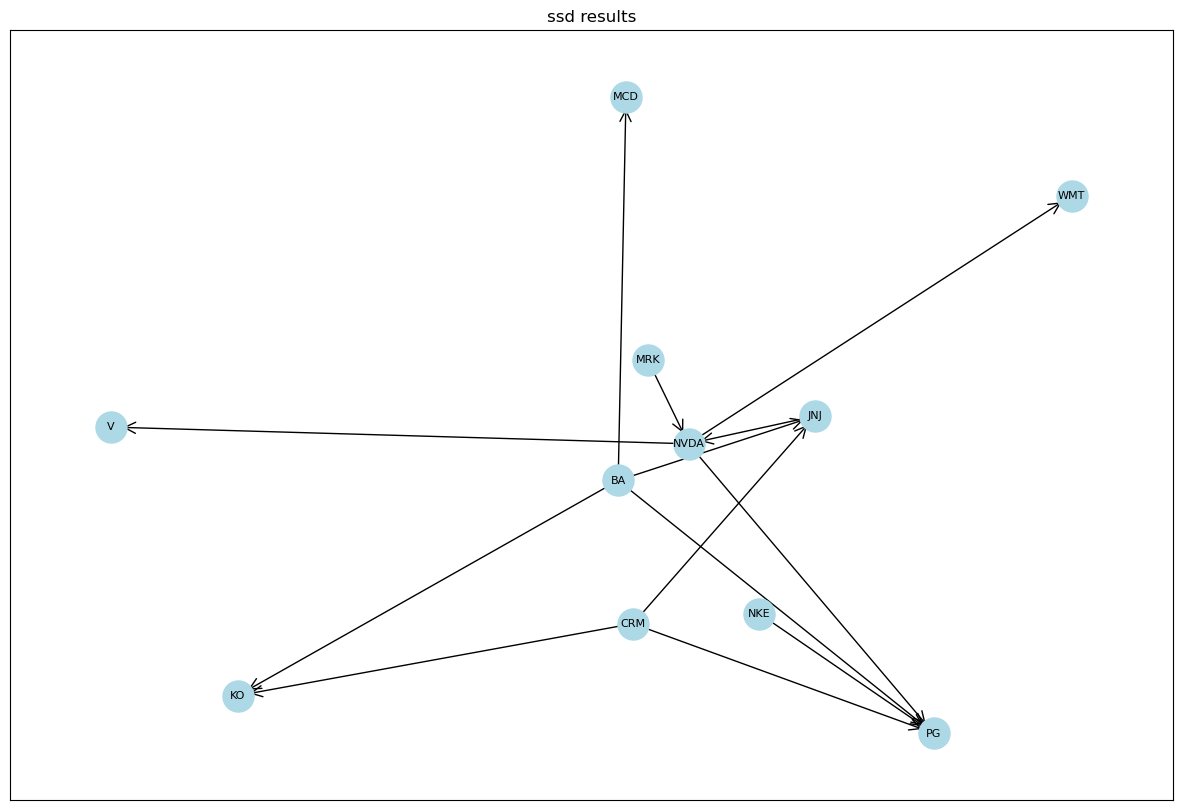

In [15]:
visualize_dominance(ssd_results,'ssd results')

## Test on trading period (13 weeks)

In [16]:
trade_pct_ret = pd.read_csv('djia_trade_pct_ret.csv')
trade_pct_ret['Date'] = pd.to_datetime(trade_pct_ret['Date'])
trade_pct_ret.set_index('Date', inplace=True, drop=True)

In [17]:
fsd_results = run_dominance_tests(trade_pct_ret, order=1)

Order 1 SD: 100%|██████████| 435/435 [04:21<00:00,  1.67it/s]


In [19]:
fsd_results

,Dominant,Dominated,Test Statistic,p-value,Adj. p-value,Significant
349,KO,NVDA,0.615385,0.0037,1.0,False
361,MCD,NVDA,0.538462,0.0111,1.0,False
359,MCD,MSFT,0.538462,0.0120,1.0,False
322,JNJ,NVDA,0.538462,0.0120,1.0,False
307,IBM,NVDA,0.461538,0.0431,1.0,False
...,...,...,...,...,...,...
286,HON,MCD,0.000000,1.0000,1.0,False
67,AMZN,IBM,0.000000,1.0000,1.0,False
157,CAT,VZ,0.000000,1.0000,1.0,False
93,AXP,IBM,0.000000,1.0000,1.0,False


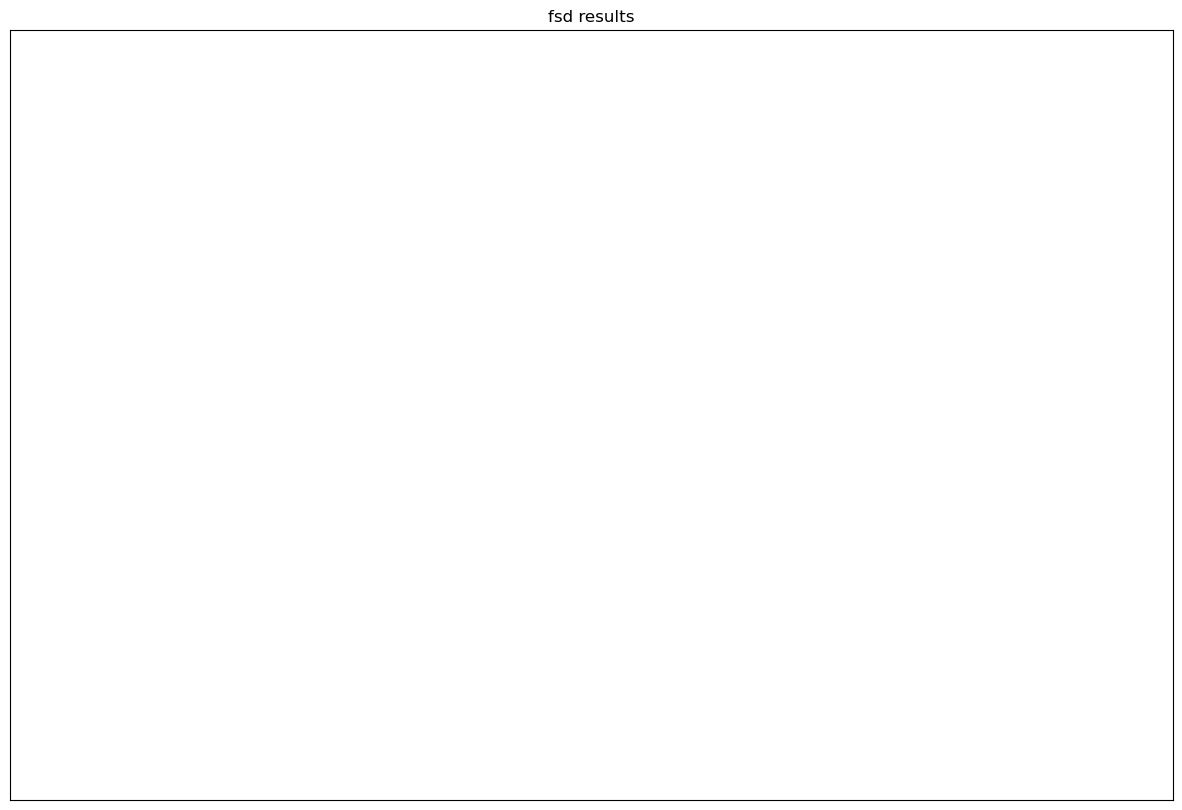

In [18]:
visualize_dominance(fsd_results,'fsd results')